**NAME:**NOORA HARIS

**STUDENT ID:**HAR23620161


IMPORT MODULES

In [1]:
!pip install librosa
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

LOAD AND EXPLORE THE DATA

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
dataset_path='/content/drive/MyDrive/CREMA-D/AudioWAV'


In [5]:
files = os.listdir('/content/drive/MyDrive/CREMA-D/AudioWAV')
print("Sample files in directory:", files[:5])


Sample files in directory: ['1079_TSI_FEA_XX.wav', '1080_DFA_SAD_XX.wav', '1079_TIE_FEA_XX.wav', '1080_DFA_DIS_XX.wav', '1079_TSI_ANG_XX.wav']


In [6]:
for root, dirs, files in os.walk('/content/drive/MyDrive/CREMA-D/AudioWAV'):
    print(f"Directory: {root}")
    print(f"Number of files: {len(files)}")
    print("-" * 50)

Directory: /content/drive/MyDrive/CREMA-D/AudioWAV
Number of files: 7442
--------------------------------------------------


In [7]:
data = []
labels = []

In [8]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)  # Taking the mean of MFCCs across time frames


In [9]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CNN_LSTM, self).__init__()
        # CNN Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Reshape x to have a single channel (1, n_mfcc, time_frames)
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, n_mfcc, time_frames)

        x = self.pool(torch.relu(self.conv1(x)))  # Apply CNN layer
        # After the CNN layer, we need to reshape the output to be compatible with LSTM
        # CNN output shape will be (batch_size, 32, n_mfcc_after_pool, time_steps_after_pool)
        x = x.view(x.size(0), x.size(2), -1)  # Reshape to (batch_size, time_steps, input_size)

        x, _ = self.lstm(x)  # Apply LSTM layer
        x = self.fc(x[:, -1, :])  # Use the last time step's output for classification
        return x


In [10]:
def extract_features(file_path):
    try:
        # Load the audio file
        print(f"Loading file: {file_path}")
        audio_data, sample_rate = librosa.load(file_path)

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
        mfccs_scaled = np.mean(mfccs.T, axis=0)

        return mfccs_scaled

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None


In [11]:
sample_file = os.path.join(dataset_path, '1001_DFA_ANG_XX.wav') # Example, replace with actual file
if os.path.exists(sample_file):
  try:
      audio_data, sample_rate = librosa.load(sample_file)
      print(f"Loaded successfully! Sample rate: {sample_rate}, Audio shape: {audio_data.shape}")
  except Exception as e:
      print(f"Error loading file: {e}")
else:
  print(f"Error: Sample file '{sample_file}' does not exist.")

Loaded successfully! Sample rate: 22050, Audio shape: (50177,)


In [12]:
EMOTION_MAP = {
    "ANG": "anger",
    "HAP": "happiness",
    "SAD": "sadness",
    "FEA": "fear",
    "DIS": "disgust",
    "NEU": "neutral"
}

for file in os.listdir('/content/drive/MyDrive/CREMA-D/AudioWAV'):
    if file.endswith(".wav"):
        file_path = os.path.join('/content/drive/MyDrive/CREMA-D/AudioWAV', file)
        emotion_code = file.split("_")[2]
        if emotion_code in EMOTION_MAP:  # Filter supported emotions
            features = extract_features(file_path)
            if features is not None:  # Ensure successful feature extraction
                data.append(features)
                labels.append(EMOTION_MAP[emotion_code])


Streaming output truncated to the last 5000 lines.
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TAI_ANG_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_WSI_SAD_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1061_DFA_SAD_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_WSI_ANG_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TSI_DIS_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TSI_ANG_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1061_DFA_DIS_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_WSI_NEU_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TSI_FEA_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TIE_HAP_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TSI_HAP_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1060_TSI_NEU_XX.wav
Loading file: /content/drive/MyDrive/CREMA-D/AudioWAV/1061_DF

EXPLORATORY DATA ANALYSIS

In [13]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' and 'labels' are lists containing the extracted features and emotion labels, respectively.
df = pd.DataFrame({'features': data, 'label': labels}) # Convert lists into a pandas dataframe called 'df'

In [14]:
# Create a DataFrame from the feature list (expanding feature arrays into separate columns)
features_df = pd.DataFrame(data)

# Add the labels as a new column
features_df['label'] = labels

# Check the structure of the DataFrame
print(features_df)

               0           1          2          3          4          5  \
0    -311.310944   80.464165  -4.113749  36.594761 -12.059236   8.862662   
1    -438.979248  133.821732   4.474387  67.072868 -15.066639  34.133228   
2    -352.238037  107.736496   2.962933  49.141251  -3.332738  11.989808   
3    -412.704926  120.979256   5.792035  63.678524 -10.684143  29.680445   
4    -330.049805   87.024178   4.340105  52.703850 -11.434691  13.988969   
...          ...         ...        ...        ...        ...        ...   
7437 -433.902496  135.099350  17.255947  55.582256  -3.495669  25.270948   
7438 -393.128296  131.255569  14.293460  50.022747  -3.061781  15.922851   
7439 -427.781708  144.250870   8.489399  59.153011  -9.023622  28.642847   
7440 -429.326691  126.840591  23.603271  61.738297  -5.814068  23.178877   
7441 -349.296326  110.750160   8.184356  48.053116  -8.183147  17.647558   

              6          7          8          9        10         11  \
0    -17.19593

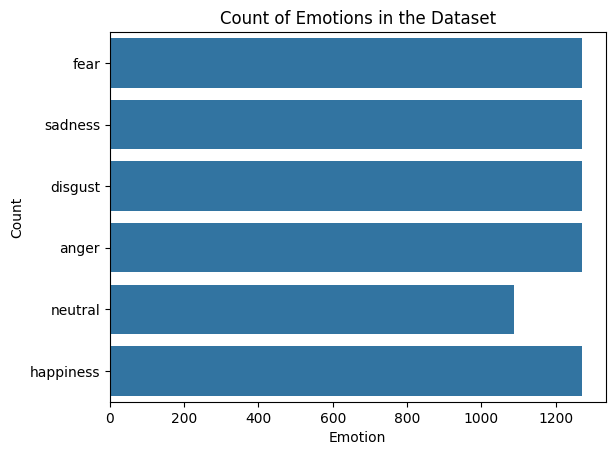

In [15]:
sns.countplot(df['label'])
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Count of Emotions in the Dataset')
plt.show()

VISUALIZE MFCCs OF A SINGLE AUDIO FILE

In [17]:
sample_file = os.path.join('/content/drive/MyDrive/CREMA-D/AudioWAV', os.listdir('/content/drive/MyDrive/CREMA-D/AudioWAV')[0])  # First audio file
y, sr = librosa.load(sample_file, sr=None)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)


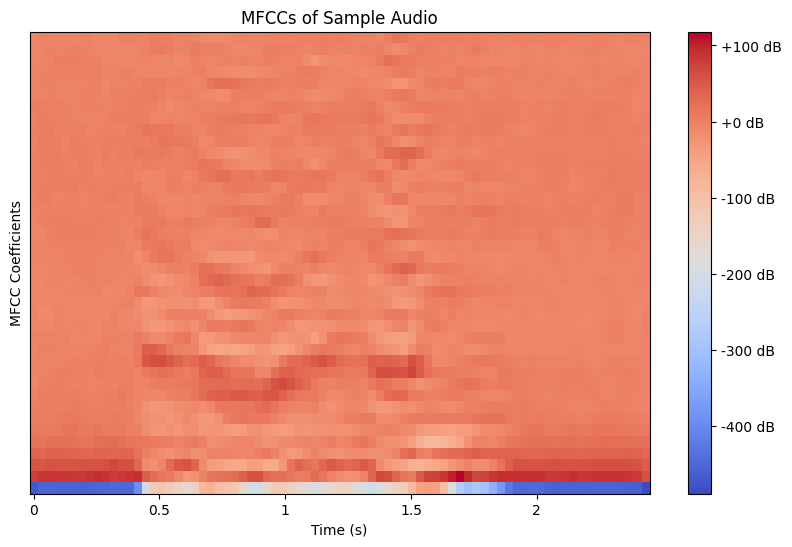

In [18]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs of Sample Audio')
plt.xlabel("Time (s)")
plt.ylabel("MFCC Coefficients")
plt.show()

ENCODE LABELS

In [19]:
!pip install scikit-learn
from sklearn.preprocessing import LabelEncoder # Import the LabelEncoder class from sklearn.preprocessing

In [20]:
label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])
print(label_encoder.classes_)


['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']


In [21]:
X = np.array(df.iloc[:, :-2])  # Features
y = np.array(df["label_encoded"])  # Encoded labels
print("Features shape:", X.shape)
print("Labels shape:", y.shape)

Features shape: (7442, 1)
Labels shape: (7442,)


In [22]:
def extract_prosodic_features(y, sr):
    try:
        # Pitch (F0) statistics
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

        # Flatten the pitch matrix and remove non-positive values
        pitches = pitches[pitches > 0]

        # Compute pitch statistics
        pitch_mean = np.mean(pitches) if pitches.size > 0 else 0
        pitch_std = np.std(pitches) if pitches.size > 0 else 0

        # Energy calculation (signal energy)
        y = y.astype(float)
        energy = np.sum(y**2) / len(y)

        # Zero-crossing rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0].mean()

        # Return the prosodic features as a numpy array
        return np.array([pitch_mean, pitch_std, energy, zero_crossing_rate])

    except Exception as e:
        print(f"Error extracting prosodic features: {e}")
        return np.zeros(4)  # Return a zero array in case of an error


In [23]:
def extract_prosodic_features(y, sr):
    # Pitch (F0) statistics
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    pitch_std = np.std(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    y = y.astype(float)
    energy = np.sum(y**2) / len(y)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0].mean()
    return np.array([pitch_mean, pitch_std, energy, zero_crossing_rate])

In [24]:
def load_crema_d_data(dataset_path):
    data = []
    for filename in os.listdir(dataset_path):
        if filename.endswith(".wav") and any(emotion in filename for emotion in ['ANG', 'FEA', 'SAD', 'DIS']):

            file_path = os.path.join(dataset_path, filename)

            # Extract information from filename
            parts = filename.split('_')
            if len(parts) < 4:
                print(f"Skipping file with unexpected format: {filename}")

                continue

            emotion = parts[2]
            intensity = parts[3].split('.')[0]  # Remove .wav extension

            # Load audio file and extract features
            y, sr = librosa.load(file_path, duration=3)  # Load up to 3 seconds

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfccs.T, axis=0)

            prosodic_features = extract_prosodic_features(y, sr)

            # Combine MFCC and prosodic features
            combined_features = np.concatenate([mfcc_mean, prosodic_features])

            # Append data
            data.append({
                'filename': filename,
                'emotion': emotion,
                'intensity': intensity,
                'features': combined_features
            })

    df = pd.DataFrame(data)
    print(f"Unique intensity values: {df['intensity'].unique()}")
    return df

In [25]:
def calculate_stress_level(emotion, intensity):
    primary_stress = {'ANG': 0.7, 'FEA': 0.7, 'SAD': 0.6}
    secondary_stress = {'DIS': 0.7}

    base_stress = 0  # Neutral baseline

    if emotion in primary_stress:
        stress_factor = primary_stress[emotion]
    elif emotion in secondary_stress:
        stress_factor = secondary_stress[emotion]
    else:  # Neutral
        stress_factor = 0

    intensity_mapping = {'LO': 0.5, 'MD': 0.75, 'HI': 1.0, 'XX': 0.5}  # XX for Unspecified

    intensity_factor = intensity_mapping.get(intensity, 0.5)  # Default to 0.5 if not found

    stress_level = base_stress + (stress_factor * intensity_factor)
    return int(stress_level > 0.5)  # Return 0 for Unstressed, 1 for Stressed

In [26]:
def load_data(df):
    df['stress_level'] = df.apply(lambda row: calculate_stress_level(row['emotion'], row['intensity']), axis=1)

    # Prepare features and labels
    X = np.stack(df['features'].values)
    y = df['stress_level'].values

    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")

    return X, y

In [30]:
# Define the Neural Network Model
class StressDetectionNN(nn.Module):
    def __init__(self, input_size):
        super(StressDetectionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [31]:

# Training function
def train_nn(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y.float())  # Squeeze to make shape compatible
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [32]:

# Load Data function
def load_data(df):

    # Calculate stress_level using calculate_stress_level function
    df['stress_level'] = df.apply(lambda row: calculate_stress_level(row['emotion'], row['intensity']), axis=1) # This line calculates the stress level

    # Prepare features and labels
    X = np.stack(df['features'].values)
    y = df['stress_level'].values

    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    return X, y

In [35]:
df = load_crema_d_data(dataset_path)

Unique intensity values: ['XX' 'HI' 'LO' 'MD' 'X']


In [39]:
X, y = load_data(df)

    # Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Shape of X: (5084, 17)
Shape of y: (5084,)


In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

    # Prepare data for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

    # Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Initialize the model, loss function, and optimizer
input_size = X_train_scaled.shape[1]
nn_model = StressDetectionNN(input_size).to(device)

In [41]:

# Main function to train and evaluate the model
def stress_detection_model():
    # Load and prepare data



    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

    # Train the model
    train_nn(nn_model, train_loader, criterion, optimizer, device)

    # Evaluate the model on the test set
    nn_model.eval()  # Switch to evaluation mode
    with torch.no_grad():
      outputs = nn_model(X_test_tensor).squeeze()  # Make predictions
      y_pred_nn = (outputs > 0.5).float().cpu()  # Move predictions to CPU and convert to float

      # Ensure y_test is a numpy array for compatibility with sklearn metrics
      if isinstance(y_test, torch.Tensor):
          y_test = y_test.cpu().numpy()

      # Convert predictions to numpy for sklearn compatibility
      y_pred_nn_numpy = y_pred_nn.numpy()

      # Calculate metrics
      accuracy = accuracy_score(y_test, y_pred_nn_numpy)
      precision = precision_score(y_test, y_pred_nn_numpy)
      recall = recall_score(y_test, y_pred_nn_numpy)
      f1 = f1_score(y_test, y_pred_nn_numpy)

      print("Neural Network Model Results:")
      print(f" Accuracy: {accuracy:.4f}")
      print(f" Precision: {precision:.4f}")
      print(f" Recall: {recall:.4f}")
      print(f" F1-score: {f1:.4f}")

    # Print classification report
      print("\nClassification Report:")
      print(classification_report(y_test, y_pred_nn_numpy, target_names=['Unstressed', 'Stressed']))

# Call the function with your dataset path


In [37]:
stress_detection_model()


Shape of X: (5084, 17)
Shape of y: (5084,)
Epoch [1/10], Loss: 0.1148
Epoch [2/10], Loss: 0.5663
Epoch [3/10], Loss: 0.0646
Epoch [4/10], Loss: 0.2476
Epoch [5/10], Loss: 0.7161
Epoch [6/10], Loss: 0.6756
Epoch [7/10], Loss: 0.0080
Epoch [8/10], Loss: 0.7058
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.5774
Neural Network Model Results:
 Accuracy: 0.9036
 Precision: 0.6667
 Recall: 0.4806
 F1-score: 0.5586

Classification Report:
              precision    recall  f1-score   support

  Unstressed       0.93      0.97      0.95       888
    Stressed       0.67      0.48      0.56       129

    accuracy                           0.90      1017
   macro avg       0.80      0.72      0.75      1017
weighted avg       0.89      0.90      0.90      1017



In [42]:
# Prediction function for new data
def predict_stress_level(model, scaler, device, input_features):
    """
    Predict the stress level for a given input feature set.

    Args:
        model (nn.Module): Trained neural network model.
        scaler (StandardScaler): Scaler object used for feature normalization.
        device (torch.device): Device where the model is located.
        input_features (numpy.ndarray): Features for a single input.

    Returns:
        float: Predicted stress level (0 or 1).
    """
    model.eval()  # Switch to evaluation mode

    # Normalize the input features
    input_features_scaled = scaler.transform([input_features])  # Ensure input is 2D
    input_tensor = torch.FloatTensor(input_features_scaled).to(device)  # Convert to tensor

    with torch.no_grad():
        prediction = model(input_tensor).squeeze()  # Get the prediction
        stress_level = (prediction > 0.5).float().item()  # Convert to binary output (0 or 1)

    return stress_level


In [55]:
# Example input feature vector (replace with actual input features)
new_input_features = X_test[19]  # Example: Use the first test input

# Predict stress level
predicted_stress = predict_stress_level(nn_model, scaler, device, new_input_features)

# Print the prediction
print(f"Predicted Stress Level: {'Stressed' if predicted_stress == 1 else 'Unstressed'}")


Predicted Stress Level: Unstressed


In [67]:

input_size = X_train.shape[1]
torch.save({
    'model_state_dict': nn_model.state_dict(),
    'input_size': input_size,
    'hidden_size': 64,  # Adjust based on your architecture
    'output_size': 3,   # Number of emotion classes
}, 'model.pth')

VISUALIZE AUDIO WAVEFORM AND SPECTROGRAM

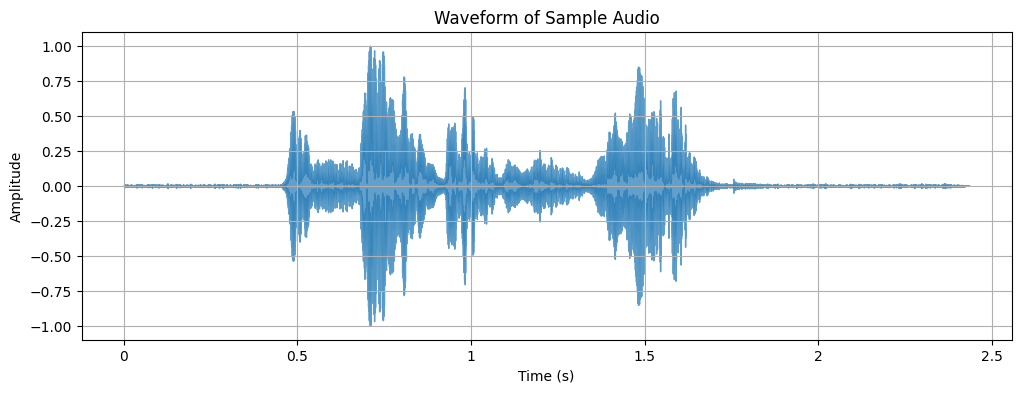

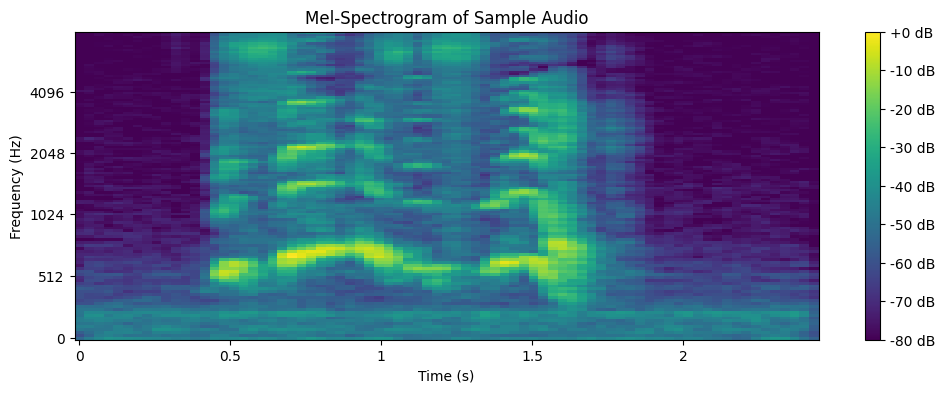

In [56]:

# Load the same sample file
y, sr = librosa.load(sample_file, sr=None)

# Plot the waveform
plt.figure(figsize=(12, 4))
plt.title('Waveform of Sample Audio')
librosa.display.waveshow(y, sr=sr, alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Plot the spectrogram
plt.figure(figsize=(12, 4))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', sr=sr, fmax=8000, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram of Sample Audio')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

CORRELATION HEATMAP FOR MFCC FEATURES

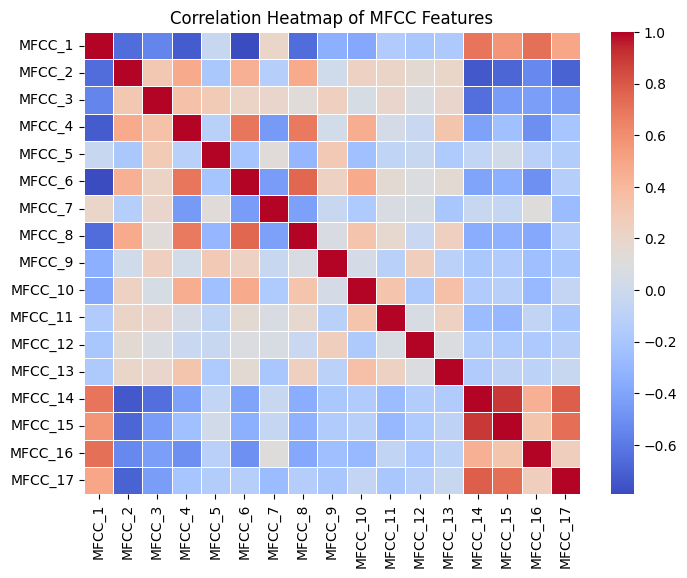

In [57]:
# Create a DataFrame for MFCC features, ensuring each element is a scalar
mfcc_df = pd.DataFrame(X, columns=[f'MFCC_{i+1}' for i in range(X.shape[1])]) # remove np.concatenate
# Convert columns containing arrays into individual scalar columns

for col in mfcc_df.columns:
    if mfcc_df[col].apply(lambda x: isinstance(x, (np.ndarray, list))).any():
        # If a column contains an array or list, expand it into multiple columns
        expanded_col = pd.DataFrame(mfcc_df[col].tolist(), index=mfcc_df.index)
        expanded_col.columns = [f'{col}_{i}' for i in range(expanded_col.shape[1])]
        mfcc_df = mfcc_df.drop(columns=[col]).join(expanded_col)

# Now you can compute the correlation matrix:
correlation_matrix = mfcc_df.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of MFCC Features")
plt.show()

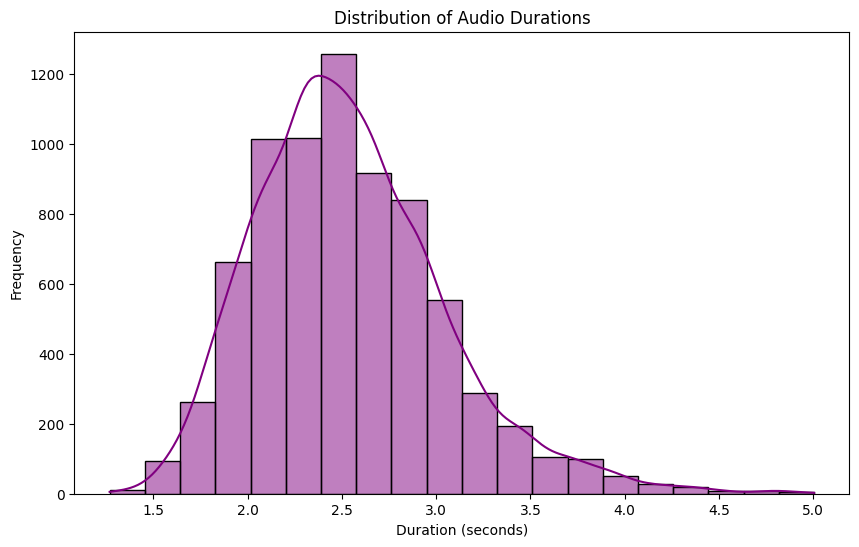

In [ ]:
# Calculate durations of all audio files
durations = []
for file in os.listdir('/content/drive/MyDrive/CREMA-D/AudioWAV'):
    if file.endswith(".wav"):
        file_path = os.path.join('/content/drive/MyDrive/CREMA-D/AudioWAV', file)
        y, sr = librosa.load(file_path, sr=None)
        durations.append(len(y) / sr)

# Plot the distribution of durations
plt.figure(figsize=(10, 6))
sns.histplot(durations, kde=True, color='purple', bins=20)
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


**EXPLANATION**

**1.Preparing the Data**

There are two key preprocessing steps:

**Feature Scaling:** StandardScaler is used to standardize the features to ensure that all input features contribute equally to the model's learning process. This step was necessary because deep learning models are sensitive to the scale of input data, and without scaling, certain features could dominate the training process.

**Label Encoding:** LabelEncoder is used to convert categorical labels (such as emotions) into numerical values. This was necessary because deep learning models require numerical data for both input and output, and label encoding allows the model to treat each emotion as a distinct class by assigning a unique numeric value to each category.

**2.Defining the Deep-Learning Model**

A Fully Connected Neural Network (FCNN) for stress detection based on extracted audio features is used here. The architecture consists of three layers:

**1. Input Layer**: The input layer receives the features extracted from audio.

**2. Hidden Layers**: Two fully connected hidden layers with 64 and 32 neurons, respectively, and ReLU activation functions to learn complex patterns.

**3. Output Layer**: A single neuron with a Sigmoid activation function to output the probability of stress.

ReLU is used here for the hidden layers because it prevents vanishing gradients and helps the network learn efficiently. Sigmoid is used at the output layer to produce probabilities for binary classification (stressed vs. unstressed). The model was trained with the Adam optimizer and Binary Cross Entropy Loss to minimize the error during training.

**3.Training and Fine-Tuning the Model**

Training involved feeding the preprocessed data through the model, calculating the error (loss), and adjusting the weights through backpropagation. The Adam optimizer and Binary Cross Entropy Loss were used to optimize the model. By fine-tuning the hyperparameters and monitoring the loss, it is possible to improve the model’s generalization capability and performance on unseen data.

Through fine-tuning, it is ensured that the model could detect stress levels effectively and efficiently.